In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read the list of filenames from the configuration file
with open('../file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = f"../data/{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])
data['date'] = pd.to_datetime(data['date'])

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

data["user"] = data["user"].replace("Banties1g", "banties_x")
data["user"] = data["user"].replace("banties1g", "banties_x")
data["user"] = data["user"].replace("chili_poe", "chili_con_bacon")
data["user"] = data["user"].replace("chili_conbacon", "chili_con_bacon")
data["user"] = data["user"].replace("Wirelesss_", "W1r3lesss")
data["user"] = data["user"].replace("treklul", "trek44_")
data["user"] = data["user"].replace("ttrek_", "trek44_")
data["user"] = data["user"].replace("TriplesingleJ", "TripleSingleJames")
data["user"] = data["user"].replace("uuccugr", "uwu_cougar")
data["user"] = data["user"].replace("uuccugr", "uuccugr_")


In [3]:
from collections import defaultdict

# Get all unique usernames
unique_users = data['user'].unique()

# Create a mapping from lowercase username to all variants

user_variants = defaultdict(set)
for user in unique_users:
    user_variants[user.lower()].add(user)

# Find usernames with different capitalization
duplicate_users = {k: v for k, v in user_variants.items() if len(v) > 1}
"""
# Display the results
for lower, variants in duplicate_users.items():
    print(f"{lower}: {sorted(variants)}")
"""

'\n# Display the results\nfor lower, variants in duplicate_users.items():\n    print(f"{lower}: {sorted(variants)}")\n'

In [4]:
# Create a mapping from all variants to the canonical (sorted first) variant
variant_map = {}
for variants in duplicate_users.values():
    sorted_variants = sorted(variants)
    canonical = sorted_variants[0]
    for v in variants:
        variant_map[v] = canonical

# Replace usernames in 'user' column
data['user'] = data['user'].apply(lambda u: variant_map.get(u, u))

In [5]:
# Find the first stream where each user sent a message
first_stream_df = data.groupby("user")["stream"].min().reset_index()
first_stream_df.rename(columns={"stream": "first_stream"}, inplace=True)

In [6]:
# Merge with the original DataFrame
data = data.merge(first_stream_df, on="user", how="left")
data.tail(10)

,date,user,message,stream,first_stream
2069907,2025-07-07 18:15:01 UTC,themightyjony,bye byeee,361,279
2069908,2025-07-07 18:15:01 UTC,kindheadbanger,Headbang,361,227
2069909,2025-07-07 18:15:01 UTC,kerm_le_groda,bye,361,360
2069910,2025-07-07 18:15:02 UTC,Georgie1471,<3 bye chat <3,361,154
2069911,2025-07-07 18:15:03 UTC,Odah_02,agabye agabye agabye agabye,361,354
2069912,2025-07-07 18:15:03 UTC,Wanderer039,o7,361,89
2069913,2025-07-07 18:15:03 UTC,Aluminiumminimumimmunity,bye bye,361,9
2069914,2025-07-07 18:15:04 UTC,Baumeister_112,bye,361,361
2069915,2025-07-07 18:15:05 UTC,greekviewer1,I AM NOT DONATING,361,165
2069916,2025-07-07 18:15:05 UTC,balintboss,I saw hassan donated 10k,361,0


In [7]:
# Count occurrences of first_stream for each stream
pivot_table = data.groupby(["stream", "first_stream"]).size().unstack(fill_value=0)

# Reset index for better readability
pivot_table = pivot_table.reset_index()

In [8]:
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Columns: 363 entries, stream to 361
dtypes: int64(363)
memory usage: 1.0 MB


In [9]:
pivot_table = pivot_table.drop(columns=['stream'])

In [10]:
pivot_table

first_stream,0,1,2,3,4,5,6,7,8,9,...,352,353,354,355,356,357,358,359,360,361
0,1985,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2105,941,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2150,204,400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1788,87,103,397,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1842,87,102,80,344,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,1361,343,20,6,5,437,2,78,21,21,...,61,42,171,171,70,1391,0,0,0,0
358,399,61,19,0,2,138,0,33,0,42,...,66,60,168,110,32,204,771,0,0,0
359,287,94,3,2,0,91,6,29,0,40,...,30,95,162,70,9,44,66,457,0,0
360,550,136,9,0,1,608,6,105,0,26,...,68,69,158,77,37,95,95,32,790,0


In [11]:


# Ensure 'date' column is datetime
data['date'] = pd.to_datetime(data['date'])

# --- FIX START ---

# 1. Sort data by date to ensure 'first()' reliably gets the earliest date
data_sorted = data.sort_values('date')

# 2. Find the actual *first date* for each stream
stream_start_dates = data_sorted.groupby('stream')['date'].first()

# 3. Get the starting period (Year-Month) for each stream
stream_start_periods = stream_start_dates.dt.to_period('M') # 'M' for monthly period

# --- FIX END ---

# Define base colors for each month (1-12) - This remains the same
base_color_map = {
    1: '#008B8B',  # Dark Cyan
    2: '#FF8C00',  # Dark Orange
    3: '#006400',  # Dark Green
    4: '#8B0000',  # Dark Red
    5: '#450145',  # Dark Purple
    6: '#00008B',  # Dark Blue
    7: '#808000',  # Olive
    8: '#006400',  # Dark Green (Note: Duplicate with 3 - consider changing)
    9: '#8B4513',  # SaddleBrown
    10: '#a10202', # Deep Red
    11: '#242323', # Dark Gray
    12: '#730049'  # Dark Magenta
}

# Function to generate shades (unchanged)
def generate_shades(base_color, n_shades, lightness_factor=0.9):
    """Generates lighter shades of a base color."""
    try:
        color_rgba = mcolors.to_rgba(base_color)
        # Create a lighter version by interpolating towards white (or a lighter fixed color)
        # This version interpolates towards white, adjusting alpha if needed
        # A simpler approach might just increase lightness in HSL space
        hsv = mcolors.rgb_to_hsv(color_rgba[:3])
        lighter_hsv = hsv.copy()
        lighter_hsv[2] = 1.0 - (1.0 - hsv[2]) * (1.0 - lightness_factor) # Adjust Value (brightness)
        lighter_rgb = mcolors.hsv_to_rgb(lighter_hsv)

        # Ensure alpha remains the same if it wasn't 1
        light_color_rgba = (*lighter_rgb, color_rgba[3])

        cmap = mcolors.LinearSegmentedColormap.from_list(
            f'shades_of_{mcolors.to_hex(base_color, keep_alpha=True)}',
             [color_rgba, light_color_rgba], N=n_shades
        )
        return [mcolors.to_hex(cmap(i), keep_alpha=True) for i in range(n_shades)] # Return hex for wider compatibility
    except ValueError:
         # Handle cases where base_color might be invalid, though map should prevent this
         print(f"Warning: Could not process base color '{base_color}'. Using gray.")
         gray_color = mcolors.to_rgba("gray")
         light_gray = mcolors.to_rgba("lightgray")
         cmap = mcolors.LinearSegmentedColormap.from_list('shades_of_gray', [gray_color, light_gray], N=n_shades)
         return [mcolors.to_hex(cmap(i), keep_alpha=True) for i in range(n_shades)]


# --- REVISED COLOR MAPPING LOGIC ---

color_list = []
# Iterate through unique *start periods* (Year-Month)
for period in sorted(stream_start_periods.unique()): # Sort periods for consistency
    # Find streams that started in this specific period
    period_streams = stream_start_periods[stream_start_periods == period].index
    n_streams_in_period = len(period_streams)

    # Get the base color using the *month* of the period
    month_num = period.month
    base_color = base_color_map.get(month_num, "#808080") # Default gray if month somehow invalid

    # Generate shades for streams starting in *this specific period*
    # Ensure at least one shade even if n_streams_in_period is 1
    shades = generate_shades(base_color, max(n_streams_in_period, 1))

    # Assign shades to streams
    for i, stream in enumerate(period_streams):
         # Handle potential edge case where generate_shades might return fewer shades than expected
         shade_index = min(i, len(shades) - 1)
         color_list.append((stream, shades[shade_index]))


# Convert to dictionary for easy lookup
color_dict = dict(color_list)

# Ensure colors match pivot table index (assuming pivot_table exists and its index is 'stream')
# Handle streams potentially missing from the data used for color generation
sorted_color_list = [color_dict.get(stream, "#808080") for stream in pivot_table.index] # Use default color for missing streams


C:\Users\Kardo\AppData\Local\Temp\ipykernel_16136\2564922726.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  stream_start_periods = stream_start_dates.dt.to_period('M') # 'M' for monthly period


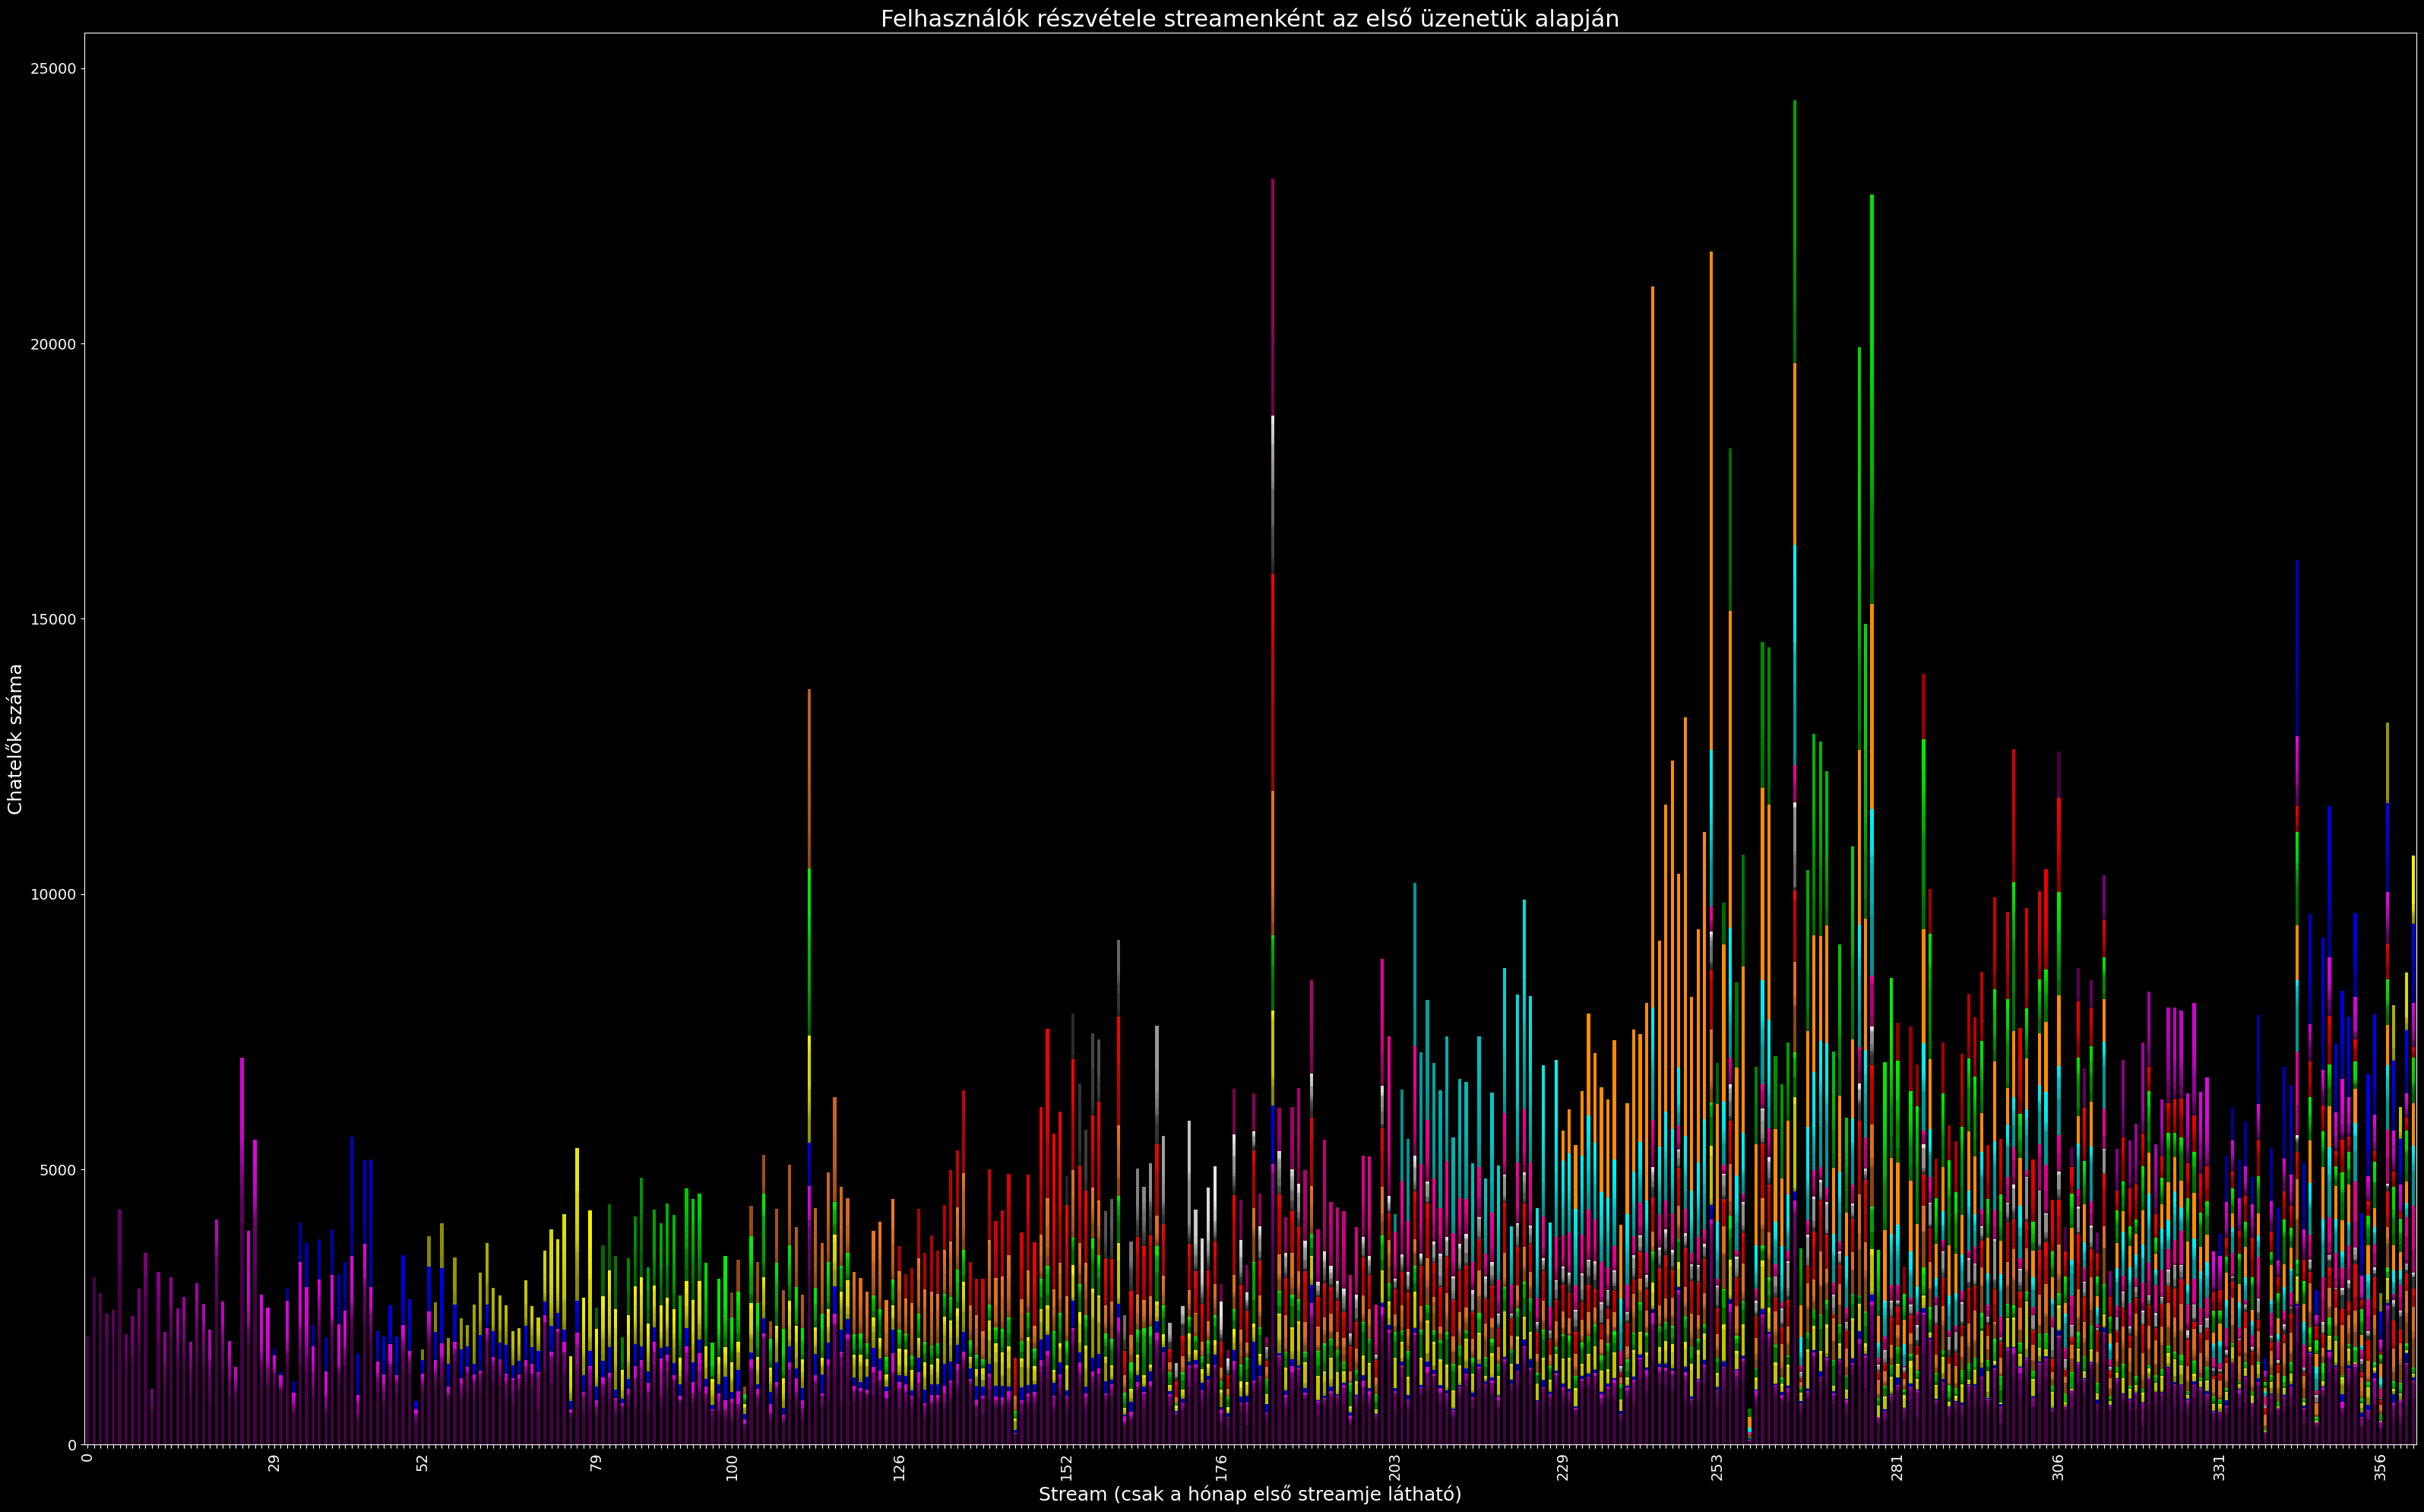

In [12]:

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(32, 20))

# Plot stacked bar chart - keep this as is
pivot_table.plot(kind='bar', stacked=True, ax=ax, color=sorted_color_list, legend=False)

# --- X-axis Label Modification Logic ---

# Get the streams in the order they appear on the plot
ordered_streams = pivot_table.index

# Get the corresponding start period (Year-Month) for each stream in plot order
# Use .reindex() to ensure alignment and handle potential missing streams gracefully
try:
    ordered_periods = stream_start_periods.reindex(ordered_streams)
except NameError:
    print("Error: 'stream_start_periods' not defined. Please run the prerequisite calculations.")
    # Optionally, provide default behavior or exit
    ordered_periods = pd.Series([None] * len(ordered_streams), index=ordered_streams) # Example fallback

# Generate the new list of labels
new_x_labels = []
last_period_shown = None

for stream, current_period in ordered_periods.items():
    # Handle streams that might not have a calculated period (e.g., not in original data)
    if pd.isna(current_period):
        # Decide how to handle streams missing period info - show label or hide?
        # Option 1: Hide label
        new_x_labels.append('')
        # Option 2: Show stream name anyway (uncomment below)
        # new_x_labels.append(stream)
        continue # Move to the next stream

    # Check if it's the first stream OR if the period (Year-Month) has changed
    if last_period_shown is None or current_period != last_period_shown:
        new_x_labels.append(stream)  # Show the stream name
        last_period_shown = current_period  # Update the last period we showed a label for
    else:
        new_x_labels.append('')  # Hide the label (same period as the previous one)

# Set the x-tick positions (0, 1, 2, ...) and the custom labels
tick_positions = range(len(ordered_streams))
ax.set_xticks(tick_positions)
ax.set_xticklabels(new_x_labels, rotation=90, fontsize=14, ha='center') # Apply new labels

# --- End X-axis Label Modification ---


# Set other plot elements
plt.title('Felhasználók részvétele streamenként az első üzenetük alapján', fontsize=22)
plt.xlabel('Stream (csak a hónap első streamje látható)', fontsize=18) # Modified label to explain
plt.ylabel('Chatelők száma', fontsize=18)

# Set y-axis font size (yticks was already done implicitly by set_xticklabels affecting both)
plt.yticks(fontsize=14)

# Optional: Add grid lines for better readability if needed
# ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [13]:
# Convert pivot table values to percentages (row-wise normalization)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100


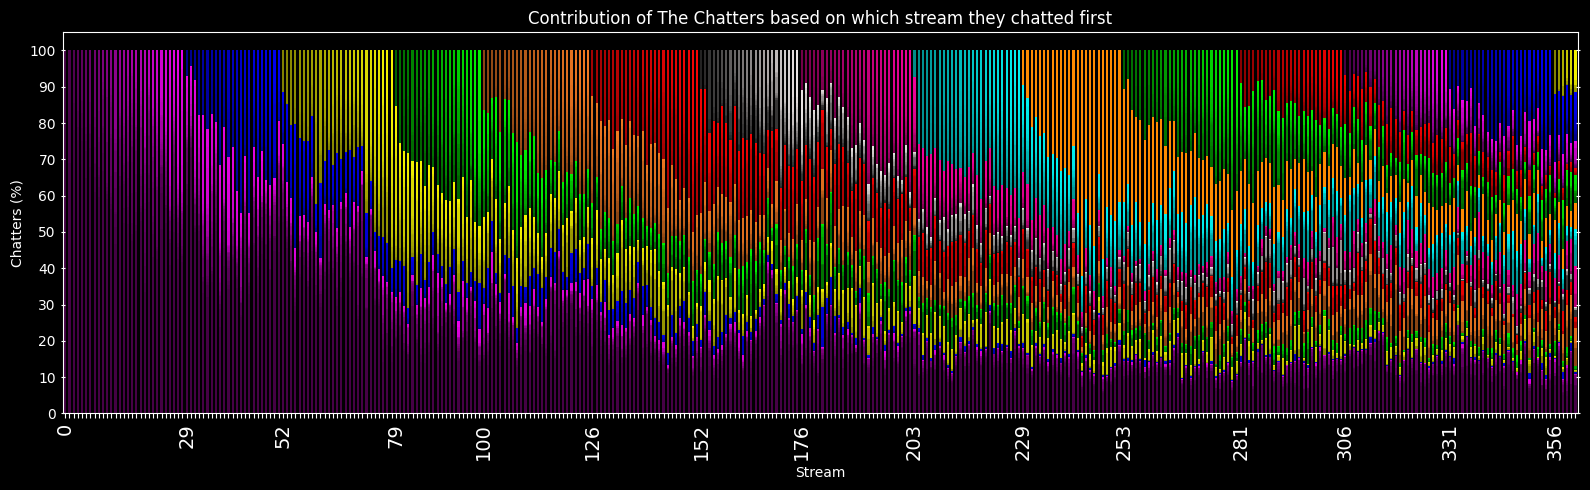

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the percentage data
plt.style.use('dark_background')
ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(16, 5), color=sorted_color_list, legend=False)

plt.title('Contribution of The Chatters based on which stream they chatted first')

# Adjust x and y labels
plt.xlabel('Stream', fontsize=10)  # Make x-axis label smaller
plt.ylabel('Chatters (%)')

# Adjust y-axis ticks to show every 10
plt.yticks(np.arange(0, 101, 10))  

# Show y-axis ticks on both left and right
ax.yaxis.set_ticks_position('both')

# Set the x-tick positions (0, 1, 2, ...) and the custom labels
tick_positions = range(len(ordered_streams))
ax.set_xticks(tick_positions)
ax.set_xticklabels(new_x_labels, rotation=90, fontsize=14, ha='center') # Apply new labels

ax.tick_params(axis='y', direction='inout')

plt.tight_layout()
plt.show()

In [15]:
pivot_table_percentage

first_stream,0,1,2,3,4,5,6,7,8,9,...,352,353,354,355,356,357,358,359,360,361
0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,69.107026,30.892974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,78.068264,7.407407,14.524328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,75.284211,3.663158,4.336842,16.715789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,75.030550,3.543788,4.154786,3.258656,14.012220,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,10.382180,2.616523,0.152567,0.045770,0.038142,3.333588,0.015257,0.595011,0.160195,0.160195,...,0.465329,0.320391,1.304447,1.304447,0.533984,10.611031,0.000000,0.000000,0.000000,0.000000
358,5.000627,0.764507,0.238125,0.000000,0.025066,1.729540,0.000000,0.413586,0.000000,0.526382,...,0.827171,0.751974,2.105527,1.378619,0.401053,2.556711,9.662865,0.000000,0.000000,0.000000
359,4.681129,1.533192,0.048932,0.032621,0.000000,1.484260,0.097863,0.473006,0.000000,0.652422,...,0.489317,1.549503,2.642310,1.141739,0.146795,0.717664,1.076496,7.453923,0.000000,0.000000
360,6.416988,1.586746,0.105005,0.000000,0.011667,7.093688,0.070004,1.225061,0.000000,0.303349,...,0.793373,0.805040,1.843426,0.898378,0.431688,1.108389,1.108389,0.373352,9.217128,0.000000


In [16]:
#pivot_table.to_excel('your_excel_file.xlsx', sheet_name='Pivot Table')